# Анализ лояльности пользователей Яндекс Афиши


- Автор: Кочетков Никита
- Дата: 20.12.2025

## Этапы выполнения проекта

### Цели и задачи проекта

**Цель:** Провести исследовательский анализ поведения пользователей сервиса Яндекс Афиша, чтобы выделить тех, кто с большей вероятностью вернется на платформу и сделают повторные заказы.

**Задачи:**
1. Подготовить необходимый запрос и загрузить данные.
2. Провести предобработку данных.
3. Создать профиль пользователя.
4. Провести исследовательский анализ данных.
5. Сформулировать выводы по проведённому анализу.


### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишием SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используем следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используем запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL позволит собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа;
- `order_ts` — дата и время создания заказа;
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_name` - название мероприятия;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Произведем предварительную устанвоку библиотеки phik
!pip install phik

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

In [3]:
# Запишем данные, необходимые для подключения, в объект
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

# Сформируем строку подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
# Передаем данные по соединению в функцию
engine = create_engine(connection_string)

Для дальнейшей работы запишем SQL запрос в переменную, чтобы можно было удобно его редактировать при необходимости

In [5]:
query = '''
SELECT user_id,
  device_type_canonical,
  order_id,
  created_dt_msk as order_dt,
  created_ts_msk as order_ts,
  currency_code,
  revenue,
  tickets_count,
  EXTRACT(DAY FROM (created_dt_msk - LAG(created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk))) AS days_since_prev,
  event_id,
  event_name_code as event_name,
  event_type_main,
  service_name,
  region_name,
  city_name
FROM afisha.purchases
LEFT JOIN afisha.events as e USING(event_id)
LEFT JOIN afisha.city as c USING(city_id)
LEFT JOIN afisha.regions as r USING(region_id)
WHERE (device_type_canonical = 'mobile' OR device_type_canonical = 'desktop') AND event_type_main != 'фильм'
ORDER BY user_id;
''' 

In [6]:
# Запишем результат запроса в датафрейм
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучим общую информацию о выгруженных данных. Оценим корректность выгрузки и объём полученных данных.

---

Познакомимся с данными датафрейма `df` — выведем первые строки методом `head()`, а саму информацию методом `info()`:

In [7]:
# Выводим первые строки датафрейма на экран
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [8]:
# Выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Датафейм `df` содержит 15 столбцов и 290611 строк, в которых представлена информация об пользователях Яндекс Афиши.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов уже имеют удобный формат, поэтому перевод под тип snake case не требуется.
- Представленные данные содержат числовые значения, текстовые и временные:
    - Значения в столбцах `user_id`, `device_type_canonical`, `currency_code`, `event_name`, `event_type_main`, `service_name`, `region_name` и `city_name` представлены типом данных `object`;
    - Значения в столбцах `revenue` и `days_since_prev` представлены типом данных `float64`. Однако, столбец с `days_since_prev` можно превести к типу `int64`, так как количетсво прошедних дней выражается целым числом. Также его можно в последующем оптимизировать с уменьшением разрядности;
    - Значение в столбцах `order_id`, `tickets_count` и `event_id` представлены типом данных `int64`.Данные показатели также можно оптимизировать.
    - Значение в столбцах `order_dt` и `order_ts` представлены типом данных `datetime64`.
    - Пропуски содержатся только в столбце `days_since_prev`.

Изучим объемы пропусков

In [9]:
# Применяем метод isna() к датафрейму df
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64

In [10]:
# Подсчитываем долю строк с пропусками
df.isna().sum() / df.shape[0]

user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
order_dt                 0.000000
order_ts                 0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
days_since_prev          0.075472
event_id                 0.000000
event_name               0.000000
event_type_main          0.000000
service_name             0.000000
region_name              0.000000
city_name                0.000000
dtype: float64

В датафрейме `df` обнаружено 21933 пропусков в столбце `days_since_prev` — это 7,55% данных.
Как мы можем помнить, данные пропуски обусловлены простановкой значения `NULL` для тех колиентов, которые совершили только одну покупку

---

### Промежуточный вывод


По итогам предварительного анализа видно: 
- Датафрейм имеет корректные значения в столбцах, соответсвующие описанию;
- Названия приведены к формату snake case, а сами данные требуют лишь оптимизационные мероприятия;
- Датаферйм `df` содержит 15 столбцов и 290611 строк;
- Пропуски обнаружены только в столбце `days_since_prev`(7,5% данных), однако они обусловлены простановкой значения `NULL` для тех колиентов, которые совершили только одну покупку


---

###  2. Предобработка данных

---

**Задача 2.1:** Так как данные о выручке сервиса представлены в российских рублях и казахстанских тенге, то привем выручку к единой валюте — российскому рублю.

Для этого используем датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`.

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраним в новый столбец `revenue_rub`.

---


In [11]:
# Выгружаем данные в переменные revenue_df
revenue_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [12]:
# Выводим первые строки датафрейма на экран
revenue_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Создадим промежуточный датафрейм. Это позволит расчитать значения в рублях для данных в казахстанского тенге.
Для этого соединим исходный с датафреймом курсом валюты по столбцам `order_dt` из первого и `data` из второго. Это позволит произвести корректный расчет валюты на актуальную дату курса.

In [13]:
# Для объединения датафреймов преобразуем столбец data из revenue_df
revenue_df['data'] = pd.to_datetime(revenue_df['data'])

In [14]:
# Объединим датафреймы
df_currency = df.merge(revenue_df, left_on='order_dt',right_on='data', how = 'left')

In [15]:
# Проверим результат
df_currency.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-20,100,18.6972,kzt
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,2024-07-23,100,18.3419,kzt
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,2024-10-06,100,19.6475,kzt
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,2024-07-13,100,18.5010,kzt
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,2024-10-04,100,19.6648,kzt


Напишем функцию для перевода курса валюты казахстанского тенге к российскому рублю за 2024 год.

Однако, предварительно проверим столбец `currency_code` на наличие других обозначений.

In [16]:
df_currency['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

Можем заметить, что иных обозначений в столбец нет. Следовательно можно произвести расчет валют по их буквенному обозначению.

In [17]:
# Функция перевода курса валюты
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        return round(row['revenue'] * (row['curs'] / 100),2)
    else:
        return 'Нет сопадений'

In [18]:
# Добавим певеденные данные пок урсу валют в исходный датафрейм df в столбец revenue_rub
df['revenue_rub'] = df_currency.apply(convert_to_rub, axis=1)

In [19]:
# Проверим результат
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


---

**Задача 2.2:**

- Перепроверим данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуем типы данных в столбцах, описанные ранее.
- Изучим значения в ключевых столбцах. Обработаем ошибки, если обнаружим их.
    - Проверим, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведем нормализацию данных, если это необходимо.
    - Проверим распределение численных данных и наличие в них выбросов. Для этого используем статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверим данные в этих столбцах.
        
Если обнаружим выбросы в поле `revenue_rub`, то отфильтруем значения по 99 перцентилю.

---

In [20]:
# Выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [21]:
# Выводим количество и процент пропущенных строк в датафрейме
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Количество пропусков': missing_data, 'Процент пропусков': missing_percent})
display(missing_df[missing_df['Количество пропусков'] > 0])

,Количество пропусков,Процент пропусков
days_since_prev,21933,7.55


Как и было проверено ранее, в датафрейме `df` обнаружено 21933 пропусков в столбце `days_since_prev` — это 7,55% данных, однако данные пропуски обусловлены простановкой значения `NULL` для тех колиентов, которые совершили только одну покупку. Поэтому можно с увереностью сказать, что в датафрейме отсутвуют непредвиденные пропуски.

Выполним преобразование типов данных:

In [22]:
# Преобразование с понижением разрядности
for column in ['order_id','tickets_count','event_id']:
    df[column] = pd.to_numeric(df[column], downcast='integer')

# Проверим результат преобразования
display(df[['order_id','tickets_count','event_id']].dtypes)

order_id         int32
tickets_count     int8
event_id         int32
dtype: object

In [23]:
# Преобразование с понижением разрядности
for column in ['revenue','revenue_rub','days_since_prev']:
    df[column] = pd.to_numeric(df[column], downcast='float')

# Проверим результат преобразования
display(df[['revenue','revenue_rub','days_since_prev']].dtypes)

revenue            float32
revenue_rub        float32
days_since_prev    float32
dtype: object

In [24]:
# Проверим типы данных в датафрейме df с помощью атрибута dtypes
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int32
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float32
tickets_count                      int8
days_since_prev                 float32
event_id                          int32
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
revenue_rub                     float32
dtype: object

Проверим данные на наличие явных и неявных дубликатов. Начнём с полных дубликатов:

In [25]:
# Проверяем полные дубликаты в датафрейме df
df.duplicated().sum()

0

В датафрейме нет полных дубликатов строк. Проверим неявные дубликаты — значения по `order_id` должны быть уникальными, то есть каждая строка в данных — уникальный заказ:

In [26]:
# Проверяем неявные дубликаты в датафрейме df
df.duplicated(subset='order_id').sum()

0

Тут тоже всё хорошо — каждая строка соответствует уникальному заказу. Теперь проверим корректность написания категориальных значений.

In [27]:
# Проверяем уникальные значения в категориальных столбцах
for column in ['device_type_canonical', 'currency_code', 'event_type_main']:
    print(f'Уникальные значения в столбце {column}:')
    print(df[column].sort_values().unique())
    print()

Уникальные значения в столбце device_type_canonical:
['desktop' 'mobile']

Уникальные значения в столбце currency_code:
['kzt' 'rub']

Уникальные значения в столбце event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']



Значения в столбах уникальны. Корректировки не требуются.
Также проверим объемные данные, однако предвариетльно нормализуем данные к одному регистру для удобства работы с ними.

In [28]:
# Выведем изначальный вариант для сравнения
display(df[['service_name', 'region_name', 'city_name']])

,service_name,region_name,city_name
0,Край билетов,Каменевский регион,Глиногорск
1,Мой билет,Каменевский регион,Глиногорск
2,За билетом!,Каменевский регион,Глиногорск
3,Лови билет!,Североярская область,Озёрск
4,Билеты без проблем,Озернинский край,Родниковецк
...,...,...,...
290606,Весь в билетах,Каменевский регион,Глиногорск
290607,Весь в билетах,Каменевский регион,Глиногорск
290608,Прачечная,Каменевский регион,Глиногорск
290609,Билеты без проблем,Широковская область,Ягодиновка


In [29]:
# Напишем функцию для корректировки значений в столбцах
def correct_name(df):
    corrected_values = []
    for value in df:
        # Удалим пробелы в начале и конце названия, а также приведём всё к нижнему регистру
        value = value.strip().lower()
        # Заменим пробелы на подчёркивания
        value = value.replace(' ', '_')
        corrected_values.append(value)
    return corrected_values

In [30]:
# Произведем корректирвоку значений
df['service_name'] = correct_name(df['service_name'])
df['region_name'] = correct_name(df['region_name'])
df['city_name'] = correct_name(df['city_name'])
# Выведем результат
display(df[['service_name', 'region_name', 'city_name']])

,service_name,region_name,city_name
0,край_билетов,каменевский_регион,глиногорск
1,мой_билет,каменевский_регион,глиногорск
2,за_билетом!,каменевский_регион,глиногорск
3,лови_билет!,североярская_область,озёрск
4,билеты_без_проблем,озернинский_край,родниковецк
...,...,...,...
290606,весь_в_билетах,каменевский_регион,глиногорск
290607,весь_в_билетах,каменевский_регион,глиногорск
290608,прачечная,каменевский_регион,глиногорск
290609,билеты_без_проблем,широковская_область,ягодиновка


Также проверим на неявные дубликаты заказы без учета `order_id`. 
Вывим те позиции, которые были совершены одним и тем же `user_id` в одно и тоже время `order_ts` и с одного и того же устройства `device_type_canonical`. Важно чтобы заказ был выполнен в у одного оператора на одинковую сумму.

In [31]:
# Получаем все имена столбцов датафрейма
all_columns = df.columns

# Исключаем столбец 'исключённый_столбец' из списка всех столбцов
columns_to_check = all_columns.drop('order_id')

# Проверяем дубликаты
duplicates = df[df.duplicated(subset=columns_to_check, keep='first')]

# Выводим дубликаты
display(duplicates)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
11759,06eb7897f65b433,mobile,1123867,2024-08-13,2024-08-13 16:31:07,rub,69.820000,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,билеты_в_руки,светополянский_округ,глиноград,69.820000
53682,206ea45ec11d478,mobile,1935171,2024-10-29,2024-10-29 16:46:54,rub,601.690002,2,0.0,442183,dcf6f06f-8499-41d7-8bc2-a0e3d7afe313,концерты,билеты_в_руки,каменевский_регион,глиногорск,601.690002
57181,2564e3703075008,mobile,160922,2024-10-30,2024-10-30 10:04:15,rub,11.230000,2,0.0,589005,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,другое,лови_билет!,яблоневская_область,горяново,11.230000
74472,35c4c43710a1e8c,mobile,4536210,2024-09-28,2024-09-28 13:43:54,rub,1891.930054,6,0.0,568022,97f14a5a-80d5-49fd-aa1c-0b7b6b59ae48,концерты,мир_касс,светополянский_округ,глиноград,1891.930054
83931,3ee7dc2e115847f,mobile,3363711,2024-06-25,2024-06-25 07:32:08,rub,59.189999,3,0.0,277504,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,выставки,билеты_в_руки,нежинская_область,каменёвка,59.189999
148349,7b525118ae656af,mobile,2323916,2024-10-28,2024-10-28 08:33:04,rub,26.959999,4,0.0,588203,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,лучшие_билеты,чистогорская_область,песчанская,26.959999
154035,7eb4fc207ecc10f,mobile,5372831,2024-08-23,2024-08-23 14:08:19,rub,126.839996,1,0.0,298035,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,другое,билеты_без_проблем,североярская_область,озёрск,126.839996
154048,7eb4fc207ecc10f,mobile,5372628,2024-08-23,2024-08-23 14:08:19,rub,126.839996,1,0.0,298035,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,другое,билеты_без_проблем,североярская_область,озёрск,126.839996
154847,7eb4fc207ecc10f,mobile,3463732,2024-09-21,2024-09-21 11:43:58,rub,2.540000,1,0.0,448579,a751c430-d352-44d7-99a0-29e97193eba5,спорт,лови_билет!,североярская_область,озёрск,2.540000
156095,7eb4fc207ecc10f,mobile,6657995,2024-10-26,2024-10-26 09:39:03,rub,294.850006,3,0.0,418836,a4478837-4631-4e28-95d7-a4c26751a232,другое,лови_билет!,тепляковская_область,горнодолинск,294.850006


In [32]:
# Введем количество дубликатов
display(len(duplicates))

31

Найдено 31 совпадающих заказов. Удалим их из итоговогог датафрейма.


In [33]:
# Удаление найденных дубликатов
df = df.drop_duplicates(subset=columns_to_check, keep='first')

In [34]:
# Выведем итоговый датафрейм
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290580 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290580 non-null  object        
 1   device_type_canonical  290580 non-null  object        
 2   order_id               290580 non-null  int32         
 3   order_dt               290580 non-null  datetime64[ns]
 4   order_ts               290580 non-null  datetime64[ns]
 5   currency_code          290580 non-null  object        
 6   revenue                290580 non-null  float32       
 7   tickets_count          290580 non-null  int8          
 8   days_since_prev        268647 non-null  float32       
 9   event_id               290580 non-null  int32         
 10  event_name             290580 non-null  object        
 11  event_type_main        290580 non-null  object        
 12  service_name           290580 non-null  obje

Проверим распределение численных данных и наличие в них выбросов. Для этого используем статистические показатели, гистограммы распределения значений или диаграммы размаха.

Выведем сводную статистику по столбцу `revenue_rub`.

In [35]:
df['revenue_rub'].describe()

count    290580.000000
mean        555.581238
std         875.520691
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

Можем заметить присутсвие аномальных занчений в данных. Так например присутствуют отрицательные значения в выручке с заказа. Что явно говорит об ошибке. Также можем заметить расхожджение между средним значением и 50% процентилем. Стандартное отклонение равно примерно 875.52 рублей, что указывает на значительное разброс значений вокруг среднего.

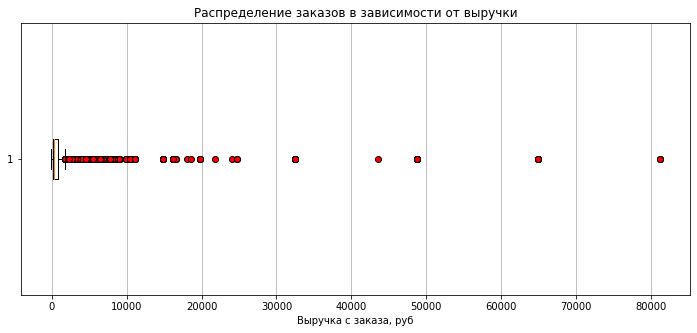

In [36]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 5))

# Строим диаграмму "ящик с усами"
bp = plt.boxplot(df['revenue_rub'],  # Убираем пропущенные значения
            vert=False,  # Устанавливаем горизонтальную ориентацию
            showfliers=True,
            flierprops=dict(markerfacecolor='r', marker='o'))  # Настраиваем вид выбросов (красные кружки)

# Настраиваем оформление графика
plt.xlabel('Выручка с заказа, руб')
plt.title('Распределение заказов в зависимости от выручки')
# Добавляем сетку графика
plt.grid(axis='x')

# Выводим график
plt.show()

Видим правосимметричное распределение данных с четким присутствием выбросов справа.

In [37]:
# Посчитаем 1 и 3 квартиль
Q1 = df['revenue_rub'].quantile(0.25)
Q3 = df['revenue_rub'].quantile(0.75)
IQR = Q3 - Q1
# Посчитаем нижний и верхний предел
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Выведем первое значение из зоны выбросов
first_up_outlier = df[df['revenue_rub'] > upper_bound]['revenue_rub'].iloc[0]
count_out = df['revenue_rub'][df['revenue_rub'] >= first_up_outlier].count()

display(f'Количество выбросов: {count_out}')
display(f'Первое значение и ряда выбросов: {first_up_outlier}')

'Количество выбросов: 4474'

'Первое значение и ряда выбросов: 2352.659912109375'

Как можем заметить, под категорию выбрасов попало 4474 значения, в которых заказ выполнен на сумму свыше 2352 руб.
Как уже обговаривалось ранее, отфильтруем данные по 99 процентилю, чтобы исключить аномальные значения.

In [38]:
# Вычисляем 99 процентиль для столбца revenue_rub
percentile_99 = df['revenue_rub'].quantile(0.99)

# Фильтруем датафрейм, оставляя только значения, которые меньше или равны 99 процентилю и убираем отрицательные значения
filtered_df = df.loc[(df['revenue_rub'] <= percentile_99) & (df['revenue_rub'] >= 0)]

Проверим результат фильтрации

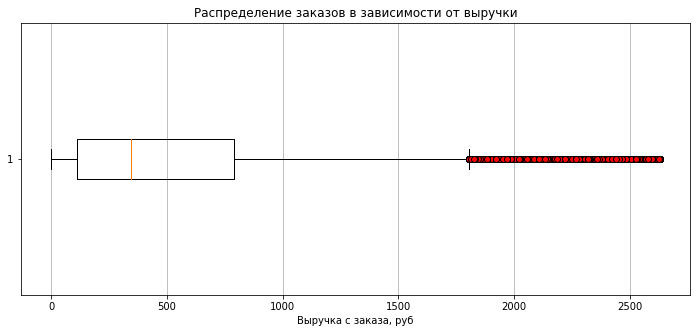

In [39]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 5))

# Строим диаграмму "ящик с усами"
bp = plt.boxplot(filtered_df['revenue_rub'],  # Убираем пропущенные значения
            vert=False,  # Устанавливаем горизонтальную ориентацию
            showfliers=True,
            flierprops=dict(markerfacecolor='r', marker='o'))  # Настраиваем вид выбросов (красные кружки)

# Настраиваем оформление графика
plt.xlabel('Выручка с заказа, руб')
plt.title('Распределение заказов в зависимости от выручки')
# Добавляем сетку графика
plt.grid(axis='x')

# Выводим график
plt.show()

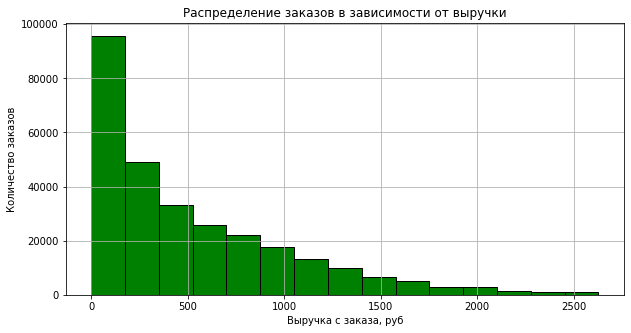

In [40]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 5))
# Строим диаграмму гистограмму распределения 
plt.hist(filtered_df['revenue_rub'],  # Убираем пропущенные значения
              bins=15,               # Количество корзин
              alpha=1,               # Устанавливаем прозрачность столбцов (1 — полностью непрозрачные)
              color='green',        # Устанавливаем цвет столбцов
              edgecolor='black')     # Устанавливаем цвет границы столбцов (чёрный)

# Настраиваем оформление графика
plt.xlabel('Выручка с заказа, руб')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов в зависимости от выручки')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [41]:
filtered_df['revenue_rub'].describe()

# Подсчитываем разницу значений
missing_data = df['revenue_rub'].count() - filtered_df['revenue_rub'].count()
missing_percent = round(100-(len(filtered_df) / len(df) * 100),2)
print({'Количество отфильтрованных значений': missing_data, 'Процент': missing_percent})

{'Количество отфильтрованных значений': 3206, 'Процент': 1.1}


Видим, что общее количество строк уменьшилось с 290580 до 287374, что составляет 3206 строк или 1,1% от исходного объема.

Также проверим распределение по столбцу `tickets_count` после фильтрации данных.

In [42]:
filtered_df['tickets_count'].describe()

count    287374.000000
mean          2.741334
std           1.163070
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

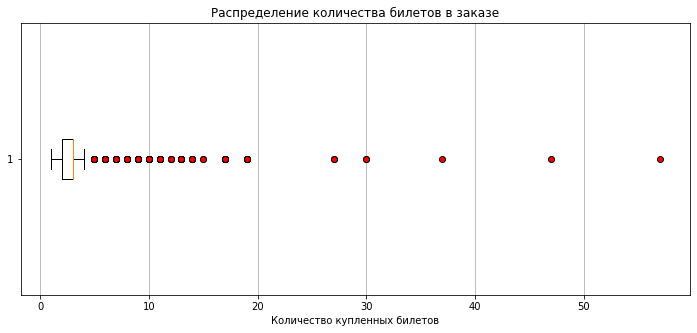

In [43]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 5))

# Строим диаграмму "ящик с усами"
bp = plt.boxplot(filtered_df['tickets_count'],  # Убираем пропущенные значения
            vert=False,  # Устанавливаем горизонтальную ориентацию
            showfliers=True,
            flierprops=dict(markerfacecolor='r', marker='o'))  # Настраиваем вид выбросов (красные кружки)

# Настраиваем оформление графика
plt.xlabel('Количество купленных билетов')
plt.title('Распределение количества билетов в заказе')
# Добавляем сетку графика
plt.grid(axis='x')

# Выводим график
plt.show()

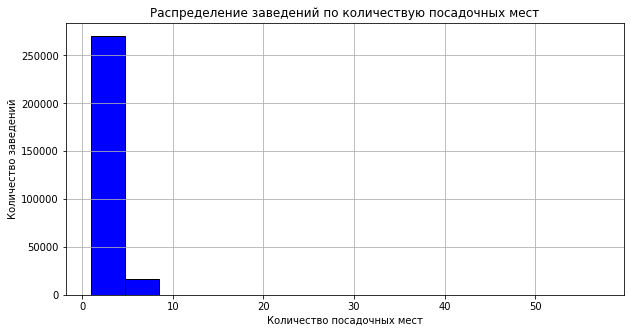

In [44]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 5))
# Строим диаграмму гистограмму распределения 
plt.hist(filtered_df['tickets_count'],  # Убираем пропущенные значения
              bins=15,               # Количество корзин
              alpha=1,               # Устанавливаем прозрачность столбцов (1 — полностью непрозрачные)
              color='blue',        # Устанавливаем цвет столбцов
              edgecolor='black')     # Устанавливаем цвет границы столбцов (чёрный)

# Настраиваем оформление графика
plt.xlabel('Количество посадочных мест')
plt.ylabel('Количество заведений')
plt.title('Распределение заведений по количествую посадочных мест')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

В данных по количеству купленных билетов также присутсвуют выбросы. Так например при среднем значении в 2,74, максимальное составляет 57. Однако их количество невелико, что и видно по стандартному отклонению равному примерно 1.16. Прослеживается умеренный разброс значений вокруг среднего.

---

**Промежуточный вывод:**

На этом предобработка завершена. Были выполнены операции по поиску пропусков и работе с ними, корректировки и оптимизации типов данных и выявлению явных/неявных дубликатов.
Если конкретнее, то были выполнены следующие действия:

- Добавлен дополнительный столбец `revenue_rub`, отображающий все заказы в руб.
- Названия столбоц не нуждались в корректировках;
- Произвдена оптимизация типов данных для столбов `order_id`,`tickets_count`,`event_id`, `revenue`,`revenue_rub`,`days_since_prev`;
- D датафрейме обнаружено 21933 пропусков в столбце days_since_prev — это 7,55% данных, однако данные пропуски обусловлены простановкой значения NULL для тех колиентов, которые совершили только одну покупку.
- Данные проверили на явные и неявные дубликаты. Найдено 31 совпадающих заказов, которые в последующем были удалены.
- Проанализировали данные по столбцам `revenue_rub` и `tickets_count`. Произвели фильтрацию данных по выбросам данных.

---

---

### 3. Создание профиля пользователя

---

**Задача 3.1.** Построим профиль пользователя. Для этого найдем:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия;
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавим два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

---

Перед формированием профиля пользователя отсортируем данные по времени совершения заказа

In [45]:
# Отсортируем данные по времени совершения заказа
sorted_df = filtered_df.sort_values(by=['user_id', 'order_ts'], ascending=True)
sorted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287374 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287374 non-null  object        
 1   device_type_canonical  287374 non-null  object        
 2   order_id               287374 non-null  int32         
 3   order_dt               287374 non-null  datetime64[ns]
 4   order_ts               287374 non-null  datetime64[ns]
 5   currency_code          287374 non-null  object        
 6   revenue                287374 non-null  float32       
 7   tickets_count          287374 non-null  int8          
 8   days_since_prev        265674 non-null  float32       
 9   event_id               287374 non-null  int32         
 10  event_name             287374 non-null  object        
 11  event_type_main        287374 non-null  object        
 12  service_name           287374 non-null  obje

Создадим профиль пользвователя:

In [46]:
# Создадим пустой датафрейм для определения профиля покупателя
user_profile = pd.DataFrame()

# Определим дату первого и последнего заказа
user_profile['first_order_date'] = sorted_df.groupby('user_id')['order_ts'].min()
user_profile['last_order_date'] = sorted_df.groupby('user_id')['order_ts'].max()

# Опредеелим устройство, с которого был сделан первый заказ
user_profile['first_device'] = sorted_df.groupby('user_id')['device_type_canonical'].first()

# Определим регион, в котором был сделан первый заказ
user_profile['first_region'] = sorted_df.groupby('user_id')['region_name'].first()

# Определим билетного партнёра, к которому обращались при первом заказе
user_profile['first_service'] = sorted_df.groupby('user_id')['service_name'].first()

# Определим жанр первого посещённого мероприятия
user_profile['first_event_type'] = sorted_df.groupby('user_id')['event_type_main'].first()

# Определим общее количество заказов пользователя
user_profile['order_count'] = sorted_df.groupby('user_id')['order_id'].count()

# Определим среднюю выручка с одного заказа в рублях
user_profile['revenue_mean'] = sorted_df.groupby('user_id')['revenue_rub'].mean()

# Определим среднее количество билетов в заказе
user_profile['tickets_mean'] = sorted_df.groupby('user_id')['tickets_count'].mean()

# Определим среднее время между заказами
# Вычисляем разницу во времени между заказами для каждого пользователя
sorted_df['time_diff'] = sorted_df.groupby('user_id')['order_ts'].diff()
# Там, где человек совершил покупку только один раз и расчет разницы выдас ошибку, заменим ее на 0
sorted_df['time_diff'] = sorted_df['time_diff'].fillna(pd.Timedelta(seconds=0))
# Переведем значения в секунды для вычисления среднего
sorted_df['time_diff_seconds'] = sorted_df['time_diff'].dt.total_seconds()
# Усредняем разницу во времени для каждого пользователя ()
user_profile['avg_time_between_orders'] = sorted_df.groupby('user_id')['time_diff_seconds'].mean()

In [47]:
# Создадим функцию, которая будет присваивать значения True или False в заисимости от количества заказов
def set_orders_flag(n):
    if n >= 5:
        return {'is_five': True, 'is_two': True}
    elif n >= 2:
        return {'is_five': False, 'is_two': True}
    else:
        return {'is_five': False, 'is_two': False}
    
#Применим функцию к датафрейму
user_profile[['is_five', 'is_two']] = user_profile['order_count'].apply(set_orders_flag).apply(pd.Series)

In [48]:
# Выведем получившийся результат
user_profile.info()
user_profile.head()

<class 'pandas.core.frame.DataFrame'>
Index: 21838 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_date         21838 non-null  datetime64[ns]
 1   last_order_date          21838 non-null  datetime64[ns]
 2   first_device             21838 non-null  object        
 3   first_region             21838 non-null  object        
 4   first_service            21838 non-null  object        
 5   first_event_type         21838 non-null  object        
 6   order_count              21838 non-null  int64         
 7   revenue_mean             21838 non-null  float32       
 8   tickets_mean             21838 non-null  float64       
 9   avg_time_between_orders  21838 non-null  float64       
 10  is_five                  21838 non-null  bool          
 11  is_two                   21838 non-null  bool          
dtypes: bool(2), d

,first_order_date,last_order_date,first_device,first_region,first_service,first_event_type,order_count,revenue_mean,tickets_mean,avg_time_between_orders,is_five,is_two
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский_регион,край_билетов,театр,1,1521.939941,4.000000,0.0,False,False
0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский_регион,мой_билет,выставки,2,774.010010,3.000000,3231589.0,False,True
000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская_область,лови_билет!,другое,3,767.213318,2.666667,2932224.0,False,True
00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский_регион,край_билетов,театр,1,917.830017,4.000000,0.0,False,False
000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский_край,лучшие_билеты,театр,2,61.309998,1.500000,674696.0,False,True


Сохраним данные по объему итогового датафрейма для дальнейшего анализа

In [49]:
user_profile_shape = user_profile.shape[0]
display(f'Объем датафрейма: {user_profile_shape} строк')

'Объем датафрейма: 21838 строк'

---

**Задача 3.2.**

Используя данные о профилях пользователей, рассчитаем:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучим статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оценим данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов

In [50]:
# Общее чисто пользователей в выборке
user_count = user_profile.shape[0]
display(f'Количество пользователей в выборке составляет: {user_count} человек.')

# Средняя выручка с одного заказа
all_revenue_mean = user_profile['revenue_mean'].mean().round()
display(f'Средняя выручка с одного заказа составляет: {all_revenue_mean} руб.')

# Доля пользователей, совершивших 2 и более заказа
per_is_two = (user_profile['is_two'].sum() / user_count).round(2)
display(f'Доля пользователей, совершивших 2 и более заказа составляет: {per_is_two}.')

# Доля пользователей, совершивших 5 и более заказа
per_is_five = (user_profile['is_five'].sum() / user_count).round(2)
display(f'Доля пользователей, совершивших 5 и более заказа составляет: {per_is_five}.')

'Количество пользователей в выборке составляет: 21838 человек.'

'Средняя выручка с одного заказа составляет: 545.0 руб.'

'Доля пользователей, совершивших 2 и более заказа составляет: 0.62.'

'Доля пользователей, совершивших 5 и более заказа составляет: 0.29.'

Изучим статистические показатели:

1) Оценим распределение данных по заказам и построим визуализацию

In [51]:
user_profile['order_count'].describe()

count    21838.000000
mean        13.159355
std        121.565063
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10168.000000
Name: order_count, dtype: float64

Можно заметить, что при среднем значении в 13, стандартное отклонение составляет 121,57, что указывает на огромный разброс значений вокруг среднего. Это и не удивительно, ведь если минимальное значение равно 1, то максимальное - 10168. Общий объем данных насчитывает 21838 строк, что является достаточным объемом для дальнейших действий. Однако, необходима фильтрация, так как такой разброс явно будет сильно влиять на результат данных.

Отфильтруем данные по 95 процентилю, чтобы исключить аномальные значения.

In [52]:
# Вычисляем 95 процентиль для столбца order_count
percentile_95 = user_profile['order_count'].quantile(0.95)

# Фильтруем датафрейм, оставляя только значения, которые меньше или равны 95 процентилю и убираем отрицательные значения
user_profile = user_profile.loc[user_profile['order_count'] <= percentile_95]

In [53]:
user_profile['order_count'].describe()

count    20747.000000
mean         4.048923
std          5.113412
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         31.000000
Name: order_count, dtype: float64

Проверим распределение заказов по среднему количеству билетов 

In [54]:
user_profile['tickets_mean'].describe()

count    20747.000000
mean         2.744535
std          0.934509
min          1.000000
25%          2.000000
50%          2.750000
75%          3.153846
max         11.000000
Name: tickets_mean, dtype: float64

Можем заметить довольно низкий показатель среднеквадратичного отклонения, а также примерное совпадение среднеарифмитеческого значения и 50% процентиля. Можно сказать, что данные по среднему количеству билетов имеют отличные показатели для дальнейшего анализа и в дополниетльнйо фильтрации не нуждаются.

Теперь проверим распределение по среднему количеству дней между покупками.
Преварительно переведем результат столбца `avg_time_between_orders` из секунд в сутки

In [55]:
user_profile['avg_time_between_orders_in_days'] = user_profile['avg_time_between_orders'] / 86400

In [56]:
user_profile['avg_time_between_orders_in_days'].describe()

count    20747.000000
mean         6.752509
std         11.177964
min          0.000000
25%          0.000000
50%          0.004682
75%         10.026513
max         74.113877
Name: avg_time_between_orders_in_days, dtype: float64

Видим, что большое значение покупателей находятся в диапазоне от 0 до 1, что говрит о преобладающем количестве людей, совершивших только одну покупку. Однако необходимо оставить эту информацию, чтобы в дальнейшем оценить какие пользователи остаются, а какие уходят.

Выведем итоговый результат фильтрации

In [57]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20747 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   first_order_date                 20747 non-null  datetime64[ns]
 1   last_order_date                  20747 non-null  datetime64[ns]
 2   first_device                     20747 non-null  object        
 3   first_region                     20747 non-null  object        
 4   first_service                    20747 non-null  object        
 5   first_event_type                 20747 non-null  object        
 6   order_count                      20747 non-null  int64         
 7   revenue_mean                     20747 non-null  float32       
 8   tickets_mean                     20747 non-null  float64       
 9   avg_time_between_orders          20747 non-null  float64       
 10  is_five                          20747 

In [58]:
user_profile.head()

,first_order_date,last_order_date,first_device,first_region,first_service,first_event_type,order_count,revenue_mean,tickets_mean,avg_time_between_orders,is_five,is_two,avg_time_between_orders_in_days
user_id,,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский_регион,край_билетов,театр,1,1521.939941,4.000000,0.0,False,False,0.000000
0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский_регион,мой_билет,выставки,2,774.010010,3.000000,3231589.0,False,True,37.402650
000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская_область,лови_билет!,другое,3,767.213318,2.666667,2932224.0,False,True,33.937778
00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский_регион,край_билетов,театр,1,917.830017,4.000000,0.0,False,False,0.000000
000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский_край,лучшие_билеты,театр,2,61.309998,1.500000,674696.0,False,True,7.808981


Отобразим результат по `по общему числу заказов`

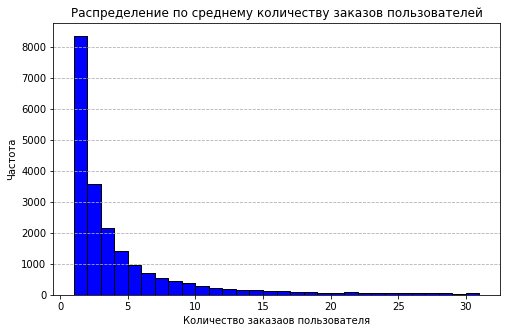

In [59]:
# Выведем данные по числу заказаов
plt.figure(figsize=(8, 5))  # устанавливаем размер рисунка
plt.hist(user_profile['order_count'], bins=30, color='blue', edgecolor='black')
plt.title('Распределение по среднему количеству заказов пользователей')
plt.xlabel('Количество заказаов пользователя')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--')
plt.show()

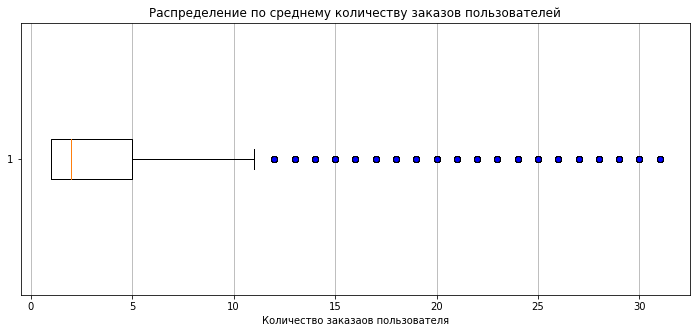

In [60]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 5))

# Строим диаграмму "ящик с усами"
bp = plt.boxplot(user_profile['order_count'],  # Убираем пропущенные значения
            vert=False,  # Устанавливаем горизонтальную ориентацию
            showfliers=True,
            flierprops=dict(markerfacecolor='b', marker='o'))  # Настраиваем вид выбросов (красные кружки)

# Настраиваем оформление графика
plt.xlabel('Количество заказаов пользователя')
plt.title('Распределение по среднему количеству заказов пользователей')
# Добавляем сетку графика
plt.grid(axis='x')

# Выводим график
plt.show()

Отобразим результат по `по среднему числу билетов в заказе`

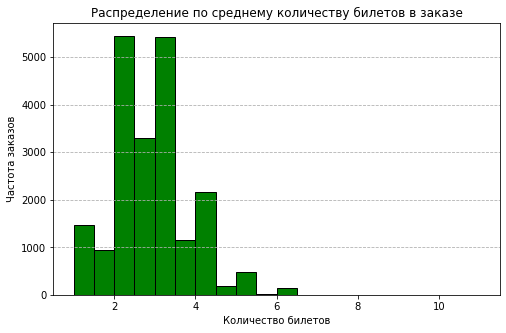

In [61]:
# Выведем данные по числу заказаов
plt.figure(figsize=(8, 5))  # устанавливаем размер рисунка
plt.hist(user_profile['tickets_mean'], bins=20, color='green', edgecolor='black')
plt.title('Распределение по среднему количеству билетов в заказе')
plt.xlabel('Количество билетов')
plt.ylabel('Частота заказов')
plt.grid(axis='y', linestyle='--')
plt.show()

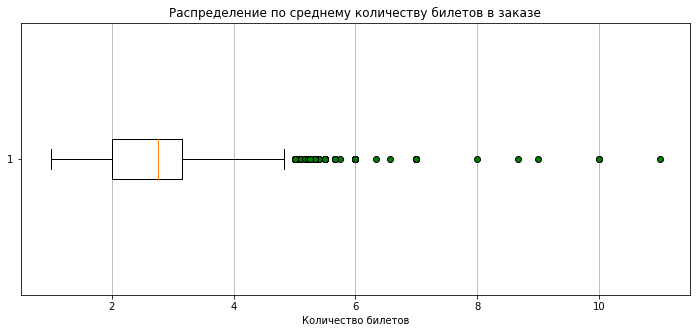

In [62]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 5))

# Строим диаграмму "ящик с усами"
bp = plt.boxplot(user_profile['tickets_mean'],  # Убираем пропущенные значения
            vert=False,  # Устанавливаем горизонтальную ориентацию
            showfliers=True,
            flierprops=dict(markerfacecolor='g', marker='o'))  # Настраиваем вид выбросов (красные кружки)

# Настраиваем оформление графика
plt.xlabel('Количество билетов')
plt.title('Распределение по среднему количеству билетов в заказе')
# Добавляем сетку графика
plt.grid(axis='x')

# Выводим график
plt.show()

Отобразим результат по `по среднему количеству дней между покупками`

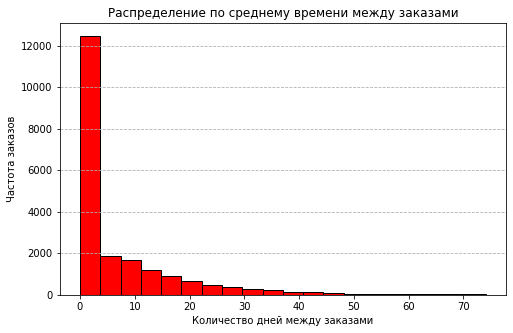

In [63]:
# Выведем данные по числу заказаов
plt.figure(figsize=(8, 5))  # устанавливаем размер рисунка
plt.hist(user_profile['avg_time_between_orders_in_days'], bins=20, color='red', edgecolor='black')
plt.title('Распределение по среднему времени между заказами')
plt.xlabel('Количество дней между заказами')
plt.ylabel('Частота заказов')
plt.grid(axis='y', linestyle='--')
plt.show()

Выведем разницу между исходным датафреймом и итоговым.

In [64]:
# Анализ разницы между датафреймами
div = user_profile_shape - user_profile.shape[0]
per_div = round(100 - (user_profile.shape[0] / user_profile_shape * 100), 1)
display(f'Разница с исходным датафреймом составляет: {div} строк или {per_div}%.')

'Разница с исходным датафреймом составляет: 1091 строк или 5.0%.'

Как итог стало ясно, что исходный датафрейм имел выбросы, которые существенно могли повлиять на результаты анализа. В связи с чем была проведена фильтрация, которая отсеила 1091 позию с аномальными значениями и уменьшила исходный датафрейм на 5,0%. Итоговый датафрейм составляет 20747 строк данных, которых достаточно для дальнейшей работы.

---

### 4. Исследовательский анализ данных




#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуем признаки, описывающие первый заказ пользователя, и выясним, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [65]:
# Информация по типу первого мероприятия
event_type_distribution = user_profile['first_event_type'].value_counts(normalize=True)
total_by_event_type = user_profile['first_event_type'].value_counts()

display(f'Распределение по меропритиям среди первых заказов')
display(total_by_event_type)

display(f'Доля мероприятий от общего количества')
display(event_type_distribution)

'Распределение по меропритиям среди первых заказов'

концерты    9191
другое      5157
театр       4070
стендап     1069
спорт        765
выставки     401
ёлки          94
Name: first_event_type, dtype: int64

'Доля мероприятий от общего количества'

концерты    0.443004
другое      0.248566
театр       0.196173
стендап     0.051526
спорт       0.036873
выставки    0.019328
ёлки        0.004531
Name: first_event_type, dtype: float64

Можем увидеть, что ТОП 3 по популярности являются: `концерты`, `другое` и `театры`. Певрое выбрали 44,3% полльзоватлей, второе - 24,8%, а третье - 19,6%. Явно, что концерты сильно выбиваются по поулярности среди остальных типов мероприятий.

In [66]:
# Информация по типу устройства для первой покупки
device_distribution = user_profile['first_device'].value_counts(normalize=True)
total_by_device = user_profile['first_device'].value_counts()

display(f'Распределение по типу устройства')
display(total_by_device)

display(f'Доля пользователей каждого устройства')
display(device_distribution)

'Распределение по типу устройства'

mobile     17208
desktop     3539
Name: first_device, dtype: int64

'Доля пользователей каждого устройства'

mobile     0.829421
desktop    0.170579
Name: first_device, dtype: float64

В подовляющем большинстве пользователи предпочитали делать свои покупки с мобильного устройства. В 83% заказов покупка совершена именно с них. Возможно сказалось удобство пользования мобильным приложением для оформления заказа.

In [67]:
# Информация по регионам проведения мероприятия
region_distribution = user_profile['first_region'].value_counts(normalize=True)
total_by_region = user_profile['first_region'].value_counts()

display(f'Распределение по регионам проведения мероприятия')
display(total_by_region)

display(f'Доля регионом с первым мероприятием пользователей')
display(region_distribution)

'Распределение по регионам проведения мероприятия'

каменевский_регион          6781
североярская_область        3599
широковская_область         1183
озернинский_край             660
малиновоярский_округ         516
                            ... 
залесский_край                 2
светолесский_край              1
яснопольский_округ             1
верхозёрский_край              1
сосноводолинская_область       1
Name: first_region, Length: 81, dtype: int64

'Доля регионом с первым мероприятием пользователей'

каменевский_регион          0.326842
североярская_область        0.173471
широковская_область         0.057020
озернинский_край            0.031812
малиновоярский_округ        0.024871
                              ...   
залесский_край              0.000096
светолесский_край           0.000048
яснопольский_округ          0.000048
верхозёрский_край           0.000048
сосноводолинская_область    0.000048
Name: first_region, Length: 81, dtype: float64

ТОП 3 регионов с меропритиями по популярности являются: `каменевский_регион`, `североярская_область` и `широковская_область`. В первом мероприятие посетили 32,7% пользоватлей, второе - 17,3%, а третье - 5,7%. Явно, что первые два региона охватывают 50% всех проведенных мероприятий.

In [68]:
# Информация по операторам мероприятия
service_distribution = user_profile['first_service'].value_counts(normalize=True)
total_by_service = user_profile['first_service'].value_counts()

display(f'Распределение по операторам мероприятия')
display(total_by_service)

display(f'Доля оператов мероприятия, выбранных пользователями')
display(service_distribution)

'Распределение по операторам мероприятия'

билеты_без_проблем        4958
мой_билет                 2853
лови_билет!               2707
билеты_в_руки             2423
облачко                   2108
весь_в_билетах            1234
лучшие_билеты             1130
прачечная                  550
край_билетов               438
дом_культуры               340
яблоко                     308
тебе_билет!                299
городской_дом_культуры     209
мир_касс                   199
за_билетом!                196
быстробилет                159
show_ticket                154
выступления.ру              92
восьмёрка                   82
быстрый_кассир              55
crazy_ticket!               42
росбилет                    40
радио_ticket                36
телебилет                   27
реестр                      27
цвет_и_билет                21
шоу_начинается!             18
карандашру                  14
кино_билет                   9
вперёд!                      7
билет_по_телефону            6
тех_билет                    3
лимоны  

'Доля оператов мероприятия, выбранных пользователями'

билеты_без_проблем        0.238974
мой_билет                 0.137514
лови_билет!               0.130477
билеты_в_руки             0.116788
облачко                   0.101605
весь_в_билетах            0.059478
лучшие_билеты             0.054466
прачечная                 0.026510
край_билетов              0.021111
дом_культуры              0.016388
яблоко                    0.014846
тебе_билет!               0.014412
городской_дом_культуры    0.010074
мир_касс                  0.009592
за_билетом!               0.009447
быстробилет               0.007664
show_ticket               0.007423
выступления.ру            0.004434
восьмёрка                 0.003952
быстрый_кассир            0.002651
crazy_ticket!             0.002024
росбилет                  0.001928
радио_ticket              0.001735
телебилет                 0.001301
реестр                    0.001301
цвет_и_билет              0.001012
шоу_начинается!           0.000868
карандашру                0.000675
кино_билет          

Самыми популярными сервисами по продаже билетов оказались: `билеты_без_проблем`, `мой_билет` и `лови_билет!`.На них приходится 50,7% всех пользователей, совершивших первый заказ.

Видно, что данные сегменты имеют расхожую статистику. Отсутсвует расвномерное распределение пользователей по различным категориям. Везде присутсвуют перевес по пользователям в тех или иных позициях.

---

**Задача 4.1.2.** Проанализируем возвраты пользователей:

- Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа
- Визуализируем результат подходящим графиком

---


In [69]:
# Информация по типу первого мероприятия для вернувшихся пользователей
event_type_returns = user_profile['first_event_type'].loc[user_profile['is_two'] == True].value_counts()
event_type_returns_distribution = event_type_returns / total_by_event_type

display(f'Распределение по меропритиям среди первых заказов для вернувшихся пользователей')
display(event_type_returns)

display(f'Доля вернувшихся пользователей')
display(event_type_returns_distribution)

'Распределение по меропритиям среди первых заказов для вернувшихся пользователей'

концерты    5539
другое      2973
театр       2518
стендап      635
спорт        414
выставки     253
ёлки          52
Name: first_event_type, dtype: int64

'Доля вернувшихся пользователей'

концерты    0.602655
другое      0.576498
театр       0.618673
стендап     0.594013
спорт       0.541176
выставки    0.630923
ёлки        0.553191
Name: first_event_type, dtype: float64

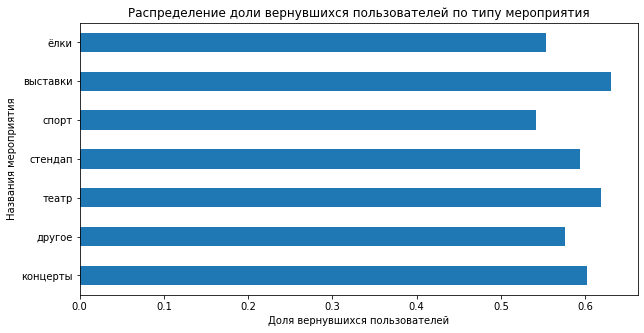

In [70]:
# Визуализируем данные
event_type_returns_distribution.plot(kind='barh', figsize=(10, 5))
plt.title('Распределение доли вернувшихся пользователей по типу мероприятия')
plt.ylabel('Названия мероприятия')
plt.xlabel('Доля вернувшихся пользователей')
plt.show()

Наблюдаем примерно одинаковое распределение по вернувшимся пользователям среди сегментов мероприятия. нельзя однознапчно назвать те, в которые люди возвращаются чаще. У всех доля вернувшихся находится в диапазооне от 54% до 63%. Чуть больше значения у `Выставки` и `Театры`, и чуть ниже у `Елки` и `Спорт`.

In [71]:
# Информация по типу устройства для первой покупки
total_by_device_returns = user_profile['first_device'].loc[user_profile['is_two'] == True].value_counts()
device_returns_distribution = total_by_device_returns / total_by_device

display(f'Распределение по типу устройства')
display(total_by_device_returns)

display(f'Доля вернувшихся пользователей')
display(device_returns_distribution)

'Распределение по типу устройства'

mobile     10189
desktop     2195
Name: first_device, dtype: int64

'Доля вернувшихся пользователей'

mobile     0.592108
desktop    0.620232
Name: first_device, dtype: float64

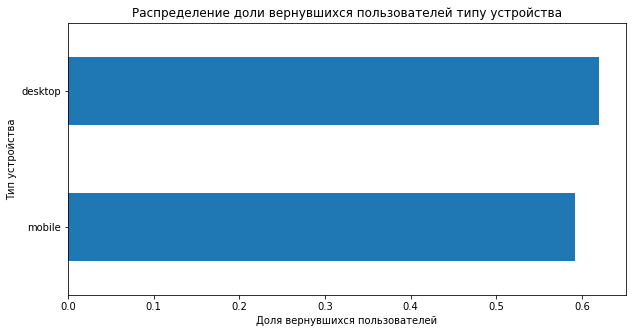

In [72]:
# Визуализируем данные
device_returns_distribution.plot(kind='barh', figsize=(10, 5))
plt.title('Распределение доли вернувшихся пользователей типу устройства')
plt.ylabel('Тип устройства')
plt.xlabel('Доля вернувшихся пользователей')
plt.show()

Аналогичная ситуация и с распределением вернувшихся в зависимости от типа устройства. Наблюдаем примерно равные значения в 59% и 62%. Нельзя точно сказать, что перевес связан с типом устройства.

In [73]:
# Информация по регионам проведения мероприятия
total_by_device_returns = user_profile['first_region'].loc[user_profile['is_two'] == True].value_counts()
region_returns_distribution = total_by_device_returns / total_by_region

display(f'Распределение по регионам проведения мероприятия ')
display(total_by_device_returns)

display(f'Доля вернувшихся пользователей')
display(region_returns_distribution)

'Распределение по регионам проведения мероприятия '

каменевский_регион      4116
североярская_область    2236
широковская_область      748
озернинский_край         358
шанырский_регион         299
                        ... 
залесский_край             1
крутоводский_регион        1
теплоозёрский_округ        1
верховинская_область       1
тихогорская_область        1
Name: first_region, Length: 77, dtype: int64

'Доля вернувшихся пользователей'

белоярская_область      0.588235
берестовский_округ      0.636364
берёзовская_область     0.634615
боровлянский_край       0.500000
верховинская_область    0.500000
                          ...   
шанырский_регион        0.645788
широковская_область     0.632291
яблоневская_область     0.581454
ягодиновская_область    0.650000
яснопольский_округ           NaN
Name: first_region, Length: 81, dtype: float64

Предварительно отсортируем результаты доли пользователей по регионам в порядке уменьшения их количества, чтобы результаты визуализации верные значения.

In [74]:
# Отсортируем показатели
sorted_total_by_device = total_by_device_returns.sort_values(ascending=False)
sorted_region_returns_distribution = region_returns_distribution[sorted_total_by_device.index]

display(f'Доля вернувшихся пользователей')
display(sorted_region_returns_distribution)

'Доля вернувшихся пользователей'

каменевский_регион      0.606990
североярская_область    0.621284
широковская_область     0.632291
озернинский_край        0.542424
шанырский_регион        0.645788
                          ...   
залесский_край          0.500000
крутоводский_регион     0.333333
теплоозёрский_округ     0.333333
верховинская_область    0.500000
тихогорская_область     0.500000
Name: first_region, Length: 77, dtype: float64

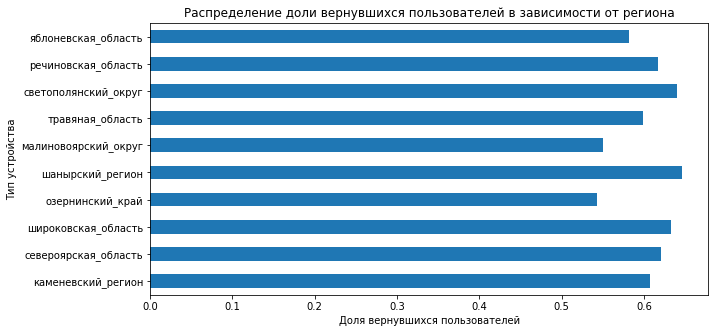

In [75]:
# Визуализируем данные
sorted_region_returns_distribution.head(10).plot(kind='barh', figsize=(10, 5))
plt.title('Распределение доли вернувшихся пользователей в зависимости от региона')
plt.ylabel('Тип устройства')
plt.xlabel('Доля вернувшихся пользователей')
plt.show()

Получаем равномерное распределение по регионам для вернувшихся пользователей. Результаты также находятся в диапазоне 54% - 64%, что говорит о низкой зависимости между возвращением пользователей и регионом. Чуть ниже значения в таких регионах как: `Малиновский округ` и `Озерненский край`, но существеных отличий не наблюдается.

In [76]:
# Информация по операторам мероприятия
total_by_service_returns = user_profile['first_service'].loc[user_profile['is_two'] == True].value_counts()
service_returns_distribution = total_by_service_returns / total_by_service

display(f'Распределение по операторам мероприятия')
display(total_by_service_returns)

display(f'Доля вернувшихся пользователей')
display(service_returns_distribution)

'Распределение по операторам мероприятия'

билеты_без_проблем        2908
мой_билет                 1691
лови_билет!               1609
билеты_в_руки             1471
облачко                   1264
весь_в_билетах             757
лучшие_билеты              673
прачечная                  332
край_билетов               280
дом_культуры               214
тебе_билет!                177
яблоко                     160
мир_касс                   124
городской_дом_культуры     120
за_билетом!                113
show_ticket                 99
быстробилет                 93
выступления.ру              56
восьмёрка                   55
быстрый_кассир              46
crazy_ticket!               28
росбилет                    26
реестр                      21
радио_ticket                15
цвет_и_билет                13
телебилет                   12
шоу_начинается!              5
билет_по_телефону            5
кино_билет                   5
карандашру                   5
вперёд!                      4
тех_билет                    1
лимоны  

'Доля вернувшихся пользователей'

crazy_ticket!             0.666667
show_ticket               0.642857
билет_по_телефону         0.833333
билеты_без_проблем        0.586527
билеты_в_руки             0.607099
быстробилет               0.584906
быстрый_кассир            0.836364
весь_в_билетах            0.613452
восьмёрка                 0.670732
вперёд!                   0.571429
выступления.ру            0.608696
городской_дом_культуры    0.574163
дом_культуры              0.629412
за_билетом!               0.576531
зе_бест!                  1.000000
карандашру                0.357143
кино_билет                0.555556
край_билетов              0.639269
лимоны                    0.500000
лови_билет!               0.594385
лучшие_билеты             0.595575
мир_касс                  0.623116
мой_билет                 0.592709
облачко                   0.599620
прачечная                 0.603636
радио_ticket              0.416667
реестр                    0.777778
росбилет                  0.650000
тебе_билет!         

Предварительно отсортируем результаты доли пользователей по операторам в порядке уменьшения их количества, чтобы результаты визуализации верные значения.

In [77]:
# Отсортируем показатели
sorted_total_by_service = total_by_service_returns.sort_values(ascending=False)
sorted_service_returns_distribution = service_returns_distribution[sorted_total_by_service.index]

display(f'Доля вернувшихся пользователей')
display(sorted_service_returns_distribution)

'Доля вернувшихся пользователей'

билеты_без_проблем        0.586527
мой_билет                 0.592709
лови_билет!               0.594385
билеты_в_руки             0.607099
облачко                   0.599620
весь_в_билетах            0.613452
лучшие_билеты             0.595575
прачечная                 0.603636
край_билетов              0.639269
дом_культуры              0.629412
тебе_билет!               0.591973
яблоко                    0.519481
мир_касс                  0.623116
городской_дом_культуры    0.574163
за_билетом!               0.576531
show_ticket               0.642857
быстробилет               0.584906
выступления.ру            0.608696
восьмёрка                 0.670732
быстрый_кассир            0.836364
crazy_ticket!             0.666667
росбилет                  0.650000
реестр                    0.777778
радио_ticket              0.416667
цвет_и_билет              0.619048
телебилет                 0.444444
шоу_начинается!           0.277778
билет_по_телефону         0.833333
кино_билет          

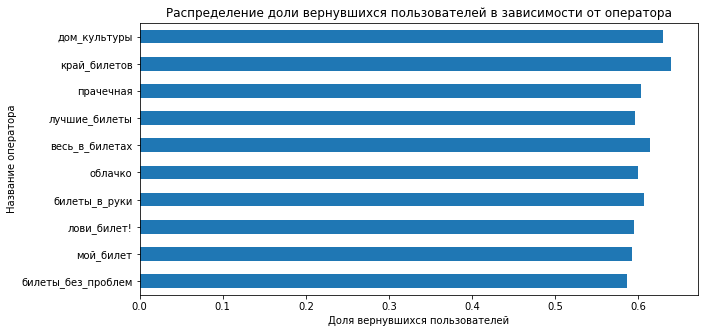

In [78]:
# Визуализируем данные
sorted_service_returns_distribution.head(10).plot(kind='barh', figsize=(10, 5))
plt.title('Распределение доли вернувшихся пользователей в зависимости от оператора')
plt.ylabel('Название оператора')
plt.xlabel('Доля вернувшихся пользователей')
plt.show()

Аналогичная ситуация с равномерным распределением наблюдается и для операторов билетного сервиса. Нет явных различий в доли вернувшихся пользователей. Незначительно выделяются такие оперторы как: `край билетов` и `дом культуры`

Из данного анализа можно сделать вывод, что возвращение пользователей на площадку малосвязано с такими параметрами как:
  - тип их первого мероприятия;
  - тип устройства, с которого совершена первая покупка;
  - регион проведения мероприятия из первого заказа;
  - билетным оператором, продавшему билеты на первый заказ.
  
Отсутсвуют очевидные "точки входа" для явного привлечения пользователей к повторной покупке.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверим продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Проверим **Гипотезу 1**. Выведем информацию о доле вернувшихся которые совершили первый заказ на спортивные мероприятия и на концерты. 

In [79]:
# Данные по концертам и спортивным мероприятиям
sport_value = event_type_returns['спорт']
concert_vlaue = event_type_returns['концерты']
display(f'Количество вернувшихся на спортивные меропрития: {sport_value}')
display(f'Количество вернувшихся на концерты: {concert_vlaue}')

sport_value_distribution = event_type_returns_distribution['спорт'].round(2)
concert_vlaue_distribution = event_type_returns_distribution['концерты'].round(2)
display(f'Доля вернувшихся на спортивные меропрития: {sport_value_distribution}')
display(f'Доля вернувшихся на концерты: {concert_vlaue_distribution}')

'Количество вернувшихся на спортивные меропрития: 414'

'Количество вернувшихся на концерты: 5539'

'Доля вернувшихся на спортивные меропрития: 0.54'

'Доля вернувшихся на концерты: 0.6'

Видим, что гипотеза не подтвердилась. Так, доля вернувшихся на концерты составляет 60%, в то время как на спортивные мероприятия - 54%. 

Проверим **Гипотезу 2**. Выведем информацию для 15 регионов с самым большим количеством пользователей и для 15 с самым малым количеством.

In [80]:
# Выведем информацию по регионам
top_region = total_by_region.head(15)
under_top_region = total_by_region.tail(15)

display(top_region)
display(under_top_region)

каменевский_регион      6781
североярская_область    3599
широковская_область     1183
озернинский_край         660
малиновоярский_округ     516
травяная_область         469
шанырский_регион         463
светополянский_округ     436
речиновская_область      421
яблоневская_область      399
верхоречная_область      374
медовская_область        357
лугоградская_область     346
серебринская_область     322
тепляковская_область     307
Name: first_region, dtype: int64

тихолесский_край            9
лесополянская_область       8
дубравная_область           5
кристальная_область         4
островогорский_округ        4
лесноярский_край            3
крутоводский_регион         3
теплоозёрский_округ         3
верховинская_область        2
тихогорская_область         2
залесский_край              2
светолесский_край           1
яснопольский_округ          1
верхозёрский_край           1
сосноводолинская_область    1
Name: first_region, dtype: int64

In [81]:
# Выведем долю вернувшихся пользователей по данным регионам
top_region_distribution = region_returns_distribution[top_region.index]
display(top_region_distribution)

# Так как в некоторых регионах с низким потоком посетителей может быть так, что ни один не вернулся, то заменим ошибки на 0
under_top_region_distribution = region_returns_distribution[under_top_region.index].fillna(0)
display(under_top_region_distribution)

каменевский_регион      0.606990
североярская_область    0.621284
широковская_область     0.632291
озернинский_край        0.542424
малиновоярский_округ    0.550388
травяная_область        0.599147
шанырский_регион        0.645788
светополянский_округ    0.639908
речиновская_область     0.617577
яблоневская_область     0.581454
верхоречная_область     0.577540
медовская_область       0.574230
лугоградская_область    0.543353
серебринская_область    0.543478
тепляковская_область    0.573290
Name: first_region, dtype: float64

тихолесский_край            0.666667
лесополянская_область       0.375000
дубравная_область           0.400000
кристальная_область         0.500000
островогорский_округ        0.000000
лесноярский_край            0.666667
крутоводский_регион         0.333333
теплоозёрский_округ         0.333333
верховинская_область        0.500000
тихогорская_область         0.500000
залесский_край              0.500000
светолесский_край           0.000000
яснопольский_округ          0.000000
верхозёрский_край           1.000000
сосноводолинская_область    0.000000
Name: first_region, dtype: float64

Расчитаем среднюю долю вернувшихся для двух этих групп и сравним

In [82]:
display(f'Среднее значение доли вернувшихся среди популярных регионов:{top_region_distribution.mean().round(2)}')
display(f'Среднее значение доли вернувшихся среди не популярных регионов:{under_top_region_distribution.mean().round(2)}')

'Среднее значение доли вернувшихся среди популярных регионов:0.59'

'Среднее значение доли вернувшихся среди не популярных регионов:0.38'

Видим, что гипотеза подтвердилась. Так, средняя доля вернувшихся в популярных регионах 59%, в то время как в непопулярных - 38%. 

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследим связь между средней выручкой сервиса с заказа и повторными заказами.

- Построим сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответим на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

---


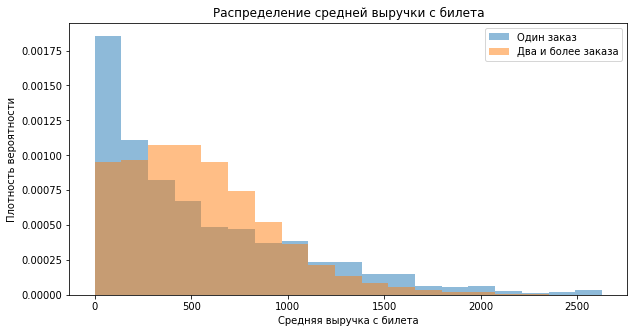

In [83]:
# Разделяем данные на группы
single_order_users = user_profile[user_profile['order_count'] == 1]
multiple_order_users = user_profile[user_profile['order_count'] >= 2]

# Определяем интервалы для гистограмм
bins = np.linspace(min(user_profile['revenue_mean']), max(user_profile['revenue_mean']), 20)

# Строим гистограммы
plt.figure(figsize=(10, 5))
plt.hist(single_order_users['revenue_mean'], bins=bins, density=True, alpha=0.5, label='Один заказ')
plt.hist(multiple_order_users['revenue_mean'], bins=bins, density=True, alpha=0.5, label='Два и более заказа')

plt.title('Распределение средней выручки с билета')
plt.xlabel('Средняя выручка с билета')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.show()

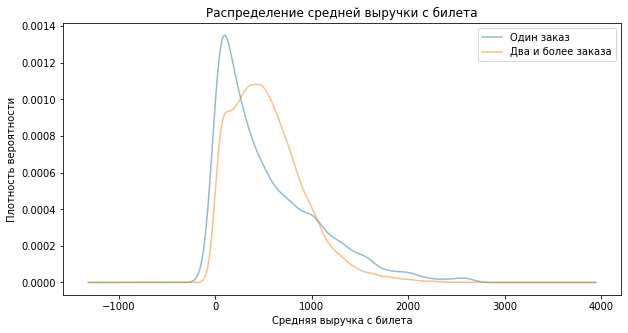

In [84]:
# Строим гистограммы с KDE
plt.figure(figsize=(10, 5))
single_order_users['revenue_mean'].plot(kind='kde', alpha=0.5, label='Один заказ')
multiple_order_users['revenue_mean'].plot(kind='kde', alpha=0.5, label='Два и более заказа')

plt.title('Распределение средней выручки с билета')
plt.xlabel('Средняя выручка с билета')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.show()

Видим, что графики распределения пользователей, сделавших один заказ и тех, кто сделал два и более, различаются. Линия первых больше смешена в начало диапазона с наименьшими значениями средней выручки, находящимися в диапазоне от 0 до 500, в то время как у вернувшихся лежит в диапазоне от 100 до 1000. Однако линия первых выше по значению плотности. Это может указывать на разброс значений.

Для более детального анализа данных рассчитаем среднее и медианное значения выручки с пользователей:

In [85]:
display('Данные по пользователям с одной покупкой')
display(single_order_users['revenue_mean'].agg(['mean', 'median']))
display('Данные по пользователям с двумя и более покупками')
display(multiple_order_users['revenue_mean'].agg(['mean', 'median']))

'Данные по пользователям с одной покупкой'

mean      545.774780
median    378.869995
Name: revenue_mean, dtype: float64

'Данные по пользователям с двумя и более покупками'

mean      548.321411
median    494.835022
Name: revenue_mean, dtype: float64

Из полученных данных можно сделать следующие выводы:

- Средняя выручка (mean) для пользователей, совершивших одну покупку, составляет 545.77, а для пользователей с двумя и более покупками — 548.32. Разница между средними значениями невелика, что говорит о том, что в среднем выручка с одного заказа примерно одинакова для обеих групп.
- Медиана выручки (median) для пользователей с одной покупкой равна 378.87, тогда как для пользователей с двумя и более покупками она составляет 494.84. Это указывает на то, что у пользователей, совершивших две и более покупки, более высокая медиана выручки, что может свидетельствовать о более высокой стабильности доходов с этой группы пользователей.

Таким образом, можно предположить, что пользователи, совершившие две и более покупок, не только приносят чуть больше выручки в среднем, но и имеют более высокую медианную выручку, что указывает на более равномерное распределение доходов в этой группе.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


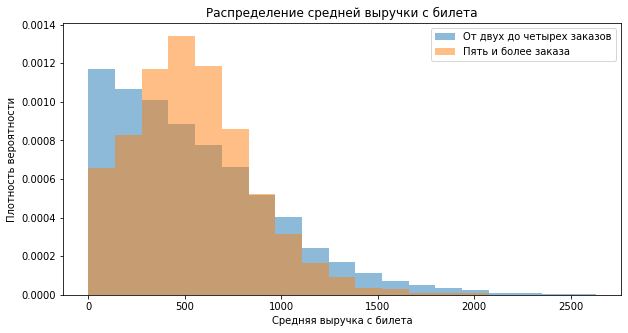

In [86]:
# Разделяем данные на группы
for_4_order_users = user_profile[(user_profile['order_count'] >= 2) & (user_profile['order_count'] <= 4)]
over_five_order_users = user_profile[user_profile['order_count'] >= 5]

# Определяем интервалы для гистограмм
bins = np.linspace(min(user_profile['revenue_mean']), max(user_profile['revenue_mean']), 20)

# Строим гистограммы
plt.figure(figsize=(10, 5))
plt.hist(for_4_order_users['revenue_mean'], bins=bins, density=True, alpha=0.5, label='От двух до четырех заказов')
plt.hist(over_five_order_users['revenue_mean'], bins=bins, density=True, alpha=0.5, label='Пять и более заказа')

plt.title('Распределение средней выручки с билета')
plt.xlabel('Средняя выручка с билета')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.show()

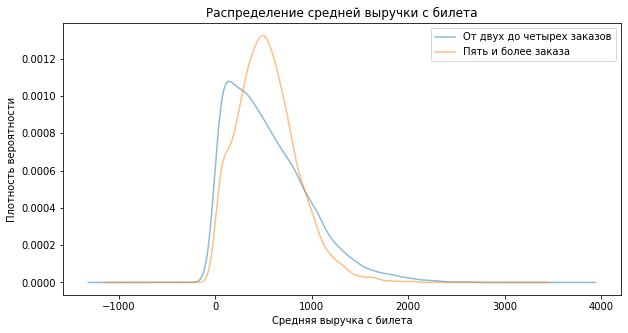

In [87]:
# Строим гистограммы с KDE
plt.figure(figsize=(10, 5))
for_4_order_users['revenue_mean'].plot(kind='kde', alpha=0.5, label='От двух до четырех заказов')
over_five_order_users['revenue_mean'].plot(kind='kde', alpha=0.5, label='Пять и более заказа')

plt.title('Распределение средней выручки с билета')
plt.xlabel('Средняя выручка с билета')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.show()

Видим, что графики распределения по пользоватлемя пользователям также имеют различия, но меньше чем для первой группы. Линия первых чуть смешена в начало диапазона с наименьшими значениями средней выручки, однако линия второйт группы выше по значению плотности, что также указывает на разброс значений.

In [88]:
display('Данные по пользователям от двух до четырех покупок')
display(for_4_order_users['revenue_mean'].agg(['mean', 'median']))
display('Данные по пользователям с пятью и более покупками')
display(over_five_order_users['revenue_mean'].agg(['mean', 'median']))

'Данные по пользователям от двух до четырех покупок'

mean      552.321533
median    472.498352
Name: revenue_mean, dtype: float64

'Данные по пользователям с пятью и более покупками'

mean      542.867737
median    515.024780
Name: revenue_mean, dtype: float64

Из полученных данных можно сделать следующие выводы:

- Средняя выручка (mean) для пользователей, совершивших от двух до четырёх покупок, составляет 552.32, что немного выше, чем у пользователей с пятью и более покупками (542.87). Это говорит о том, что в среднем пользователи из первой группы приносят чуть больше выручки на заказ.
- Медиана выручки (median) также выше у пользователей с 2–4 покупками (472.50), по сравнению с пользователями, сделавшими 5 и более покупок (515.02). Это указывает на то, что для большей части пользователей в первой группе выручка находится ниже среднего значения, тогда как у второй группы медиана ближе к среднему значению.

Таким образом, можно предположить, что пользователи, совершившие от двух до четырёх покупок, в среднем приносят немного больше выручки за заказ, но распределение выручки у них более разнообразное по сравнению с теми, кто совершил пять и более покупок.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [89]:
# Определим сегменты по среднему количеству билетов
bins = [1, 2, 3, 5, float('inf')]
labels = ['1-2 билетов', '2-3 билетов', '3-5 билетов', '5 и более билетов']

user_profile['segment'] = pd.cut(user_profile['tickets_mean'], bins=bins, labels=labels)

# Подсчитаем общее число пользователей в каждом сегменте
total_users_by_segment = user_profile.groupby('segment').count()

# Подсчитаем число пользователей, совершивших повторные заказы, в каждом сегменте
repeated_orders_users = user_profile[user_profile['order_count'] > 1]
repeated_users_count = repeated_orders_users.groupby('segment').count()

# Вычислим долю пользователей, совершивших повторные заказы
segment_repeated_ratio = repeated_users_count / total_users_by_segment

display('Количество вернувшихся пользователей по каждому сегменту')
display(total_users_by_segment['tickets_mean'])
display('Доля вернувшихся пользователей по каждому сегменту')
display(segment_repeated_ratio['tickets_mean'])                                                                           

'Количество вернувшихся пользователей по каждому сегменту'

segment
1-2 билетов          4811
2-3 билетов          9167
3-5 билетов          5240
5 и более билетов     194
Name: tickets_mean, dtype: int64

'Доля вернувшихся пользователей по каждому сегменту'

segment
1-2 билетов          0.478695
2-3 билетов          0.721392
3-5 билетов          0.619275
5 и более билетов    0.324742
Name: tickets_mean, dtype: float64

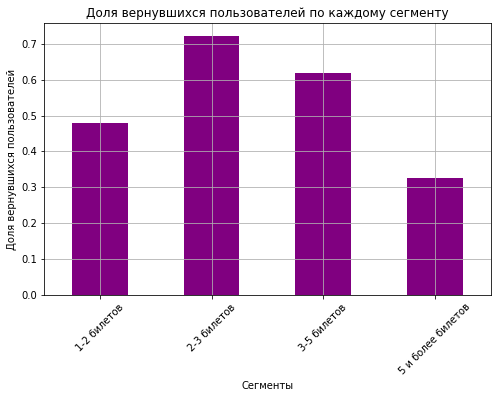

In [90]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(8, 5))

# Строим столбчатую диаграмму
segment_repeated_ratio['tickets_mean'].plot(
    kind='bar',
    rot=45,  # Градус вращения подписи по оси Х
    legend=False,  # Выключаем легенду
    color='Purple',
    title='Доля вернувшихся пользователей по каждому сегменту')

# Настраиваем оформление графика
plt.xlabel('Сегменты')
plt.ylabel('Доля вернувшихся пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Таким образом, можно заметить, что сегментация по среднему количеству билетов в заказе влияет на вероятность повторной покупки. отсутвует равномерное распределение доли вернувшихся пользователей. Наибольший процент повторных покупок наблюдается в сегменте «2-3 билета» - 72%, в то время как наименьшая — в сегменте «5 и более билетов» - 32%.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [91]:
# Выделите день недели из даты первого заказа
user_profile['day_of_week'] = user_profile['first_order_date'].dt.day_name()

In [92]:
# Подсчитаем общее число пользователей в каждом сегменте
total_users_by_day = user_profile.groupby('day_of_week').count()

# Подсчитаем число пользователей, совершивших повторные заказы, в каждом сегменте
repeated_orders_users = user_profile[user_profile['order_count'] > 1]
repeated_users_count = repeated_orders_users.groupby('day_of_week').count()

# Вычислим долю пользователей, совершивших повторные заказы
segment_repeated_ratio = repeated_users_count / total_users_by_day

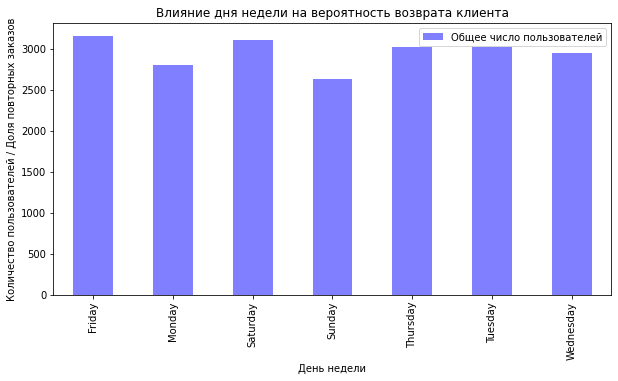

In [93]:
plt.figure(figsize=(10, 5))
total_users_by_day['first_order_date'].plot(kind='bar', color='blue', alpha=0.5, label='Общее число пользователей')
plt.title('Влияние дня недели на вероятность возврата клиента')
plt.xlabel('День недели')
plt.ylabel('Количество пользователей / Доля повторных заказов')
plt.legend()
plt.show()

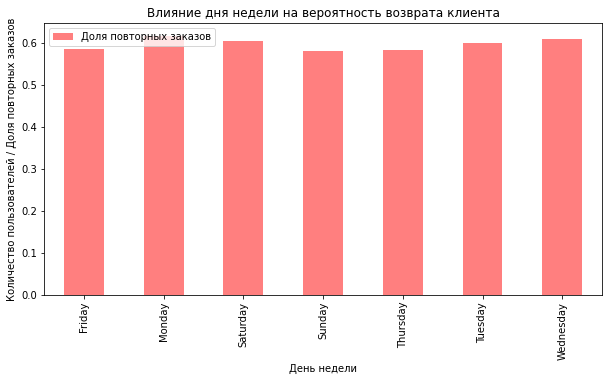

In [94]:
plt.figure(figsize=(10, 5))
segment_repeated_ratio['first_order_date'].plot(kind='bar', color='red', alpha=0.5, label='Доля повторных заказов')
plt.title('Влияние дня недели на вероятность возврата клиента')
plt.xlabel('День недели')
plt.ylabel('Количество пользователей / Доля повторных заказов')
plt.legend()
plt.show()

Можно сделать вывод, что дни недели, в которые была совершена покупка, слабо влияют на вероятность возврата клиента. Доля вернувшихся примерно равна для каждого дня недели и составляет примерно 60%.

---

**Задача 4.3.2.** Изучим, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитаем среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуем, как средний интервал между заказами влияет на вероятность повторного заказа.

---


In [95]:
# Разделяем данные на группы
for_4_order_days = user_profile[(user_profile['order_count'] >= 2) & (user_profile['order_count'] <= 4)]
over_five_order_days = user_profile[user_profile['order_count'] >= 5]

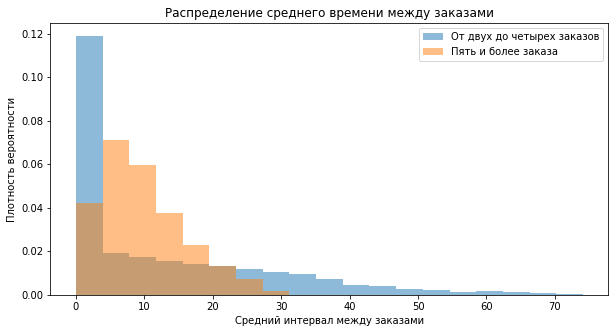

In [96]:
# Определяем интервалы для гистограмм
bins = np.linspace(min(user_profile['avg_time_between_orders_in_days']), max(user_profile['avg_time_between_orders_in_days']), 20)

# Строим гистограммы
plt.figure(figsize=(10, 5))
plt.hist(for_4_order_days['avg_time_between_orders_in_days'], bins=bins, density=True, alpha=0.5, label='От двух до четырех заказов')
plt.hist(over_five_order_days['avg_time_between_orders_in_days'], bins=bins, density=True, alpha=0.5, label='Пять и более заказа')

plt.title('Распределение среднего времени между заказами')
plt.xlabel('Средний интервал между заказами')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.show()

In [97]:
display('Среднее время между заказами по пользователям от двух до четырех покупок')
display(for_4_order_days['avg_time_between_orders_in_days'].agg(['mean', 'median']))
display('Среднее время между заказами по пользователям с пятью и более покупками')
display(over_five_order_days['avg_time_between_orders_in_days'].agg(['mean', 'median']))

'Среднее время между заказами по пользователям от двух до четырех покупок'

mean      12.521745
median     5.693968
Name: avg_time_between_orders_in_days, dtype: float64

'Среднее время между заказами по пользователям с пятью и более покупками'

mean      9.663925
median    8.610047
Name: avg_time_between_orders_in_days, dtype: float64

Из полученных данных можно сделать следующие выводы:

- Среднее время между заказами для пользователей, совершивших от двух до четырёх покупок, составляет 12.52 дня, а для пользователей с пятью и более покупками — 9.66 дней. Это говорит о том, что пользователи, совершающие больше заказов, делают это чаще, с меньшим интервалом между заказами.
- Медиана времени между заказами также ниже для группы с пятью и более покупками (8.61 дня) по сравнению с группой от двух до четырёх покупок (5.69 дней). Это указывает на то, что для большей части пользователей в первой группе интервалы между заказами более длительные.

Таким образом, можно предположить, что более короткий средний интервал между заказами способствует увеличению количества повторных заказов. Пользователи, которые совершают заказы чаще, с меньшей вероятностью будут делать длительные перерывы между покупками, что ведёт к увеличению общего числа их заказов.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

---

**Задача 4.4.1:** Проведем корреляционный анализ:
- Рассчитаем коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). 
- Проанализируем полученные результаты. Если полученные значения будут близки к нулю, проверим разброс данных в `total_orders`. Выделиим сегменты пользователей по полю `total_orders`, а затем повторим корреляционный анализ. Выделим такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируем результат корреляции с помощью тепловой карты.
---

In [98]:
# Создадим список столбцов, между которыми хотим посчитать корреляцию
corr_columns = user_profile[['order_count', 'first_device', 'first_region', 'first_service', 'first_event_type',
                             'revenue_mean', 'tickets_mean', 'avg_time_between_orders']]

correlation_matrix = corr_columns.phik_matrix(interval_cols=['order_count', 'revenue_mean', 'tickets_mean', 'avg_time_between_orders'])
display('Корреляционная матрица с коэффициентом phi_k:')
display(correlation_matrix)

'Корреляционная матрица с коэффициентом phi_k:'

,order_count,first_device,first_region,first_service,first_event_type,revenue_mean,tickets_mean,avg_time_between_orders
order_count,1.000000,0.049647,0.020049,0.038158,0.033932,0.263626,0.296889,0.605958
first_device,0.049647,1.000000,0.113156,0.081960,0.061025,0.077009,0.056967,0.023644
first_region,0.020049,0.113156,1.000000,0.695880,0.505667,0.361602,0.171807,0.090723
first_service,0.038158,0.081960,0.695880,1.000000,0.587699,0.385611,0.064763,0.044469
first_event_type,0.033932,0.061025,0.505667,0.587699,1.000000,0.334221,0.097163,0.050261
revenue_mean,0.263626,0.077009,0.361602,0.385611,0.334221,1.000000,0.451518,0.241622
tickets_mean,0.296889,0.056967,0.171807,0.064763,0.097163,0.451518,1.000000,0.230663
avg_time_between_orders,0.605958,0.023644,0.090723,0.044469,0.050261,0.241622,0.230663,1.000000


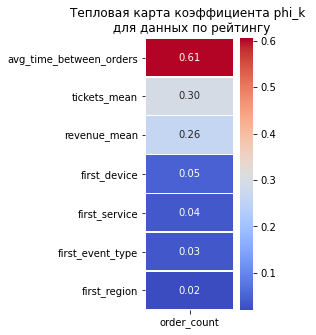

In [99]:
# Задаём размер графика
plt.figure(figsize=(2, 5))

# Создаём визуализацию
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count']].sort_values(by='order_count', ascending=False)
sns.heatmap(data=data_heatmap, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm')

# Показываем график с заголовком
plt.title('Тепловая карта коэффициента phi_k \n для данных по рейтингу')
plt.show()

Произведем разделенеи на сегменты

In [100]:
# Определим сегменты по среднему количеству билетов
user_profile['segment'] = user_profile['order_count'].apply(lambda x: '1 заказ' if x == 1 
                                                            else ('от 2 до 4 заказов' if 2 <= x <= 4 
                                                            else 'от 5 и выше'))

In [101]:
# Создадим список столбцов, между которыми хотим посчитать корреляцию
corr_columns = user_profile[['segment','order_count', 'first_device', 'first_region', 'first_service', 'first_event_type',
                             'revenue_mean', 'tickets_mean', 'avg_time_between_orders']]

correlation_matrix = corr_columns.phik_matrix(interval_cols=['order_count', 'revenue_mean', 'tickets_mean', 'avg_time_between_orders'])
display('Корреляционная матрица с коэффициентом phi_k:')
display(correlation_matrix)

'Корреляционная матрица с коэффициентом phi_k:'

,segment,order_count,first_device,first_region,first_service,first_event_type,revenue_mean,tickets_mean,avg_time_between_orders
segment,1.000000,0.776409,0.015257,0.105469,0.072904,0.040623,0.297867,0.358573,0.627288
order_count,0.776409,1.000000,0.049647,0.020049,0.038158,0.033932,0.263626,0.296889,0.605958
first_device,0.015257,0.049647,1.000000,0.113156,0.081960,0.061025,0.077009,0.056967,0.023644
first_region,0.105469,0.020049,0.113156,1.000000,0.695880,0.505667,0.361602,0.171807,0.090723
first_service,0.072904,0.038158,0.081960,0.695880,1.000000,0.587699,0.385611,0.064763,0.044469
first_event_type,0.040623,0.033932,0.061025,0.505667,0.587699,1.000000,0.334221,0.097163,0.050261
revenue_mean,0.297867,0.263626,0.077009,0.361602,0.385611,0.334221,1.000000,0.451518,0.241622
tickets_mean,0.358573,0.296889,0.056967,0.171807,0.064763,0.097163,0.451518,1.000000,0.230663
avg_time_between_orders,0.627288,0.605958,0.023644,0.090723,0.044469,0.050261,0.241622,0.230663,1.000000


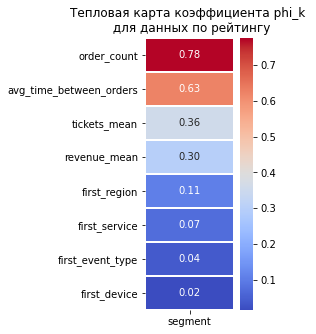

In [102]:
# Задаём размер графика
plt.figure(figsize=(2, 5))

# Создаём визуализацию
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'segment'][['segment']].sort_values(by='segment', ascending=False)
sns.heatmap(data=data_heatmap, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm')

# Показываем график с заголовком
plt.title('Тепловая карта коэффициента phi_k \n для данных по рейтингу')
plt.show()

Видим явную положительную корреляцию между количеством заказов и врменем между заказов. Также не стоит упускать из внимаение наличие средней зависимости количества купленых билетов и средней выручки с количеством заказов.

### 5. Общий вывод и рекомендации


В ходе исследования проанализировали данные по 20747 пользователям Яндекс.Афиши. Данные включали информацию о самих пользователях, регионах, меропритиях, операторов по продаже билетов, а также о выручке с них. Акцент исследования был на том, чтобы найти взаимосвязи между критериями, влияющими на возврат покупателей на платформу. Перед исследованием была проведена работа по оптимизации и нормализации исходных данных. Был произвдеен пересчет сумм из тенге в рубли, для удобства оценки.  Определены пропуски и дубликаты, искажающие результаты анализа. А также проведена оптимизация с целью исключения из итоговой выборки значений выбросов.

Анализ позволил определить:

  - чаще всего люди возвращались на такие мероприятия как: `Выставки`, `Театры` и `Концерты`;
  - связи между устройством, с которого делался первый заказ, и возвратом пользователей не найдено;
  - в регионах с большим количеством пользователей, люди чаще возвращались, чем в менее популярных;
  - в плане влияние оператора по продаже билетов тоже не выявлено явного влияния. Незначительно выделяются такиеоперторы как: `край билетов` и `дом культуры`;
  - пользователи, совершившие две и более покупок, не только приносят чуть больше выручки в среднем, но и имеют более высокую медианную выручку, что указывает на более равномерное распределение доходов чем те, кто соверших одну;
  - сегментация по среднему количеству билетов в заказе влияет на вероятность повторной покупки. Отсутвует равномерное распределение доли вернувшихся пользователей. Наибольший процент повторных покупок наблюдается в сегменте «2-3 билета» - 72%, в то время как наименьшая — в сегменте «5 и более билетов» - 32%.
  - дни недели, в которые была совершена покупка, слабо влияют на вероятность возврата клиента. Доля вернувшихся примерно равна для каждого дня недели и составляет примерно 60%.
  - более короткий средний интервал между заказами способствует увеличению количества повторных заказов. Пользователи, которые совершают заказы чаще, с меньшей вероятностью будут делать длительные перерывы между покупками, что ведёт к увеличению общего числа их заказов.
  - прослеживается явная положительная корреляция между количеством заказов и врменем между заказов. Также не стоит упускать из внимаение наличие средней зависимости количества купленых билетов и средней выручки с количеством заказов.
  
  В качетсве рекомендации стоит сказать, что стоит уделить внимание тем покупателям, которые соовершают разовую покупку менее чем на 2-3 билета, а также кто покупает более 5. Возможно стоит их мотивировать какими-нибудь бонусами или акциями для стимуляции повторного заказа и умеменьшения интервала между посещениями мероприятий.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**
https://github.com/Barmonik/yandex.afisha_analyse/tree/master